## Transmission Economic Assessment with PyPSA-USA


https://pypsa.readthedocs.io/en/latest/components.html

A simplified network of the PyPSA-USA WECC network with the following characteristics:
- 3 buses
- 3 lines
- 167 Generators (MW), listed below by fuel type
```
    CCGT          56915.400
    OCGT          35345.100
    coal          24395.000
    geothermal     3914.200
    hydro         52844.738
    nuclear        7732.600
    oil            1100.300
    onwind        28557.900
    solar         29108.000
```
- Peak Load (MW):
```
    CA    49420.22
    PNW   17931.67
    SW    30590.69
```
- Time-series data for 12 months Jan - Dec 2019

Install PyPSA and import the WECC network to visualize it and
generate a plot of the nodes and existing lines.

In [1]:
# !pip install pypsa highspy matplotlib cartopy xarray==2023.9.0
!pip install --upgrade pypsa
!pip install --upgrade xarray

In [3]:
from google.colab import drive
drive.mount('/content/drive')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Import the network

In [2]:
import pypsa
import matplotlib.pyplot as plt
network = pypsa.Network('wecc_network.nc')


Plot a network visualization

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.

/usr/local/lib/python3.10/dist-packages/cartopy/mpl/feature_artist.py:144: UserWarning:

facecolor will have no effect as it has been defined as "never".

/usr/local/lib/python3.10/dist-packages/cartopy/io/__init__.py:241: DownloadWarning:

Downloading: https://naturalearth.s3.amazonaws.com/50m_cultural/ne_50m_admin_0_boundary_lines_land.zip

/usr/local/lib/python3.10/dist-packages/cartopy/io/__init__.py:241: DownloadWarning:

Downloading: https://naturalearth.s3.amazonaws.com/50m_physical/ne_50m_coastline.zip



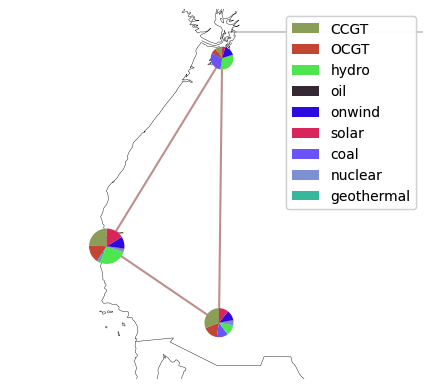

In [4]:
from pypsa.plot import add_legend_patches
import cartopy.crs as ccrs
import random

carriers = network.generators.carrier.unique()
colors = ["#%06x" % random.randint(0, 0xFFFFFF) for _ in carriers]
network.madd("Carrier", carriers, color=colors)

fig = plt.figure()
ax = plt.axes(projection=ccrs.EqualEarth())
capacities = network.generators.groupby(["bus", "carrier"]).p_nom.sum()

network.plot(
    ax=ax,
    bus_sizes=capacities / 2e5,
    margin=0.2
)

add_legend_patches(ax, colors, carriers)

The project goal is to assess whether is makes economic sense to build an additional 230kV transmission line between California and the Southwest.

To do this, load costs and adjusted production costs for the different regions in the model is compared - This will help tell a story of who, if any stakeholders, profit from a new transmission line and who, if any, lose money from it.

Simulate a sequential DCOPF of the current given network (i.e. simulate the network operation).

Relevant documentation: https://pypsa.readthedocs.io/en/latest/components.html#network

In [5]:
#network optimisiz
network.optimize(solver_name="highs")

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.

Index(['CA', 'PNW', 'SW'], dtype='object', name='Load')
Index(['CA', 'PNW', 'SW'], dtype='object', name='Bus')
Index(['CA-PNW', 'PNW-SW', 'CA-SW'], dtype='object', name='Line')
Index(['CA', 'PNW', 'SW'], dtype='object', name='Load')
Index(['CA', 'PNW', 'SW'], dtype='object', name='Bus')
Index(['CA-PNW', 'PNW-SW', 'CA-SW'], dtype='object', name='Line')
Writing continuous variables.: 100%|██████████| 2/2 [00:03<00:00,  1.77s/it]


('ok', 'optimal')

Create a labeled time-series plot of the Locational Marginal Prices (LMPs) for the first week of January, 2019.

Relevant documentation: https://pypsa.readthedocs.io/en/latest/components.html#bus

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



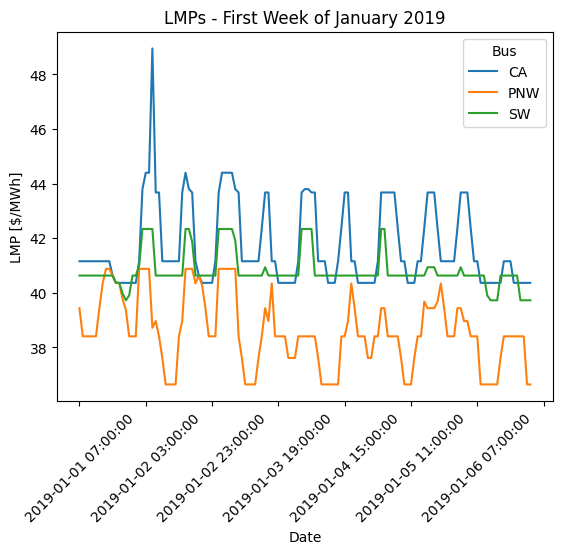

In [6]:
#TODO
LMP = network.buses_t.marginal_price
LMP_firstweek = LMP.loc['2019-01-01':'2019-01-07']
LMP_firstweek.plot()

plt.title('LMPs - First Week of January 2019')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.ylabel('LMP [$/MWh]')
plt.legend(title='Bus')
plt.show()

Get a visualization of the dispatch by fuel type for the first week

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.

<ipython-input-7-a9d26634cb69>:4: FutureWarning:

DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.



Text(0, 0.5, 'GW')

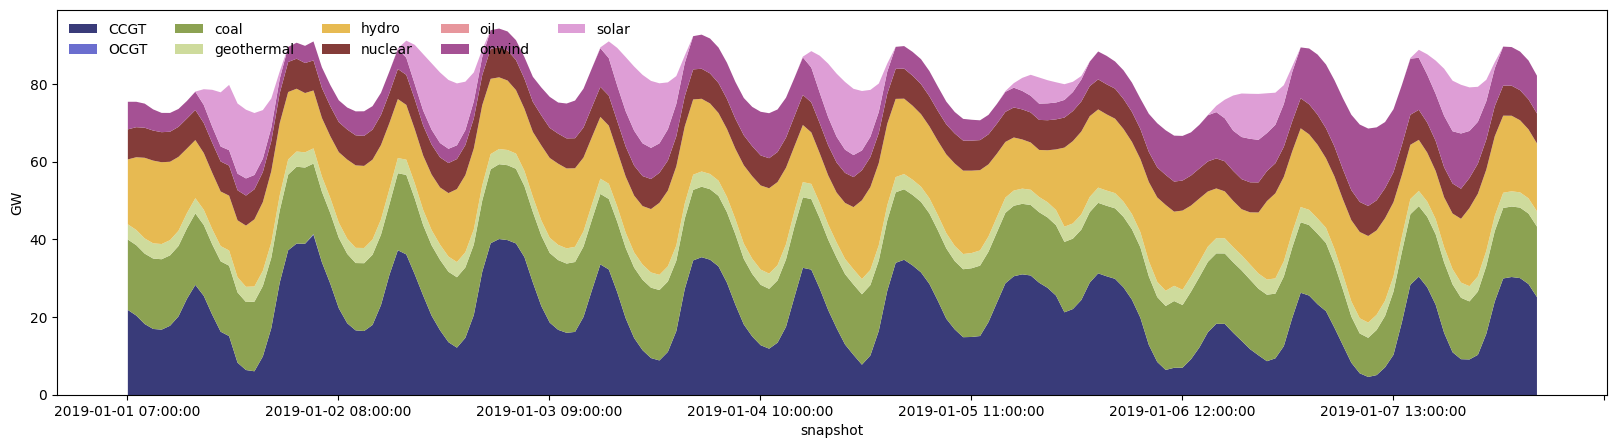

In [7]:
#Dispatch plot of first week
nhours = 24*7
fig, ax = plt.subplots(figsize=(20, 5))
p_by_carrier = network.generators_t.p.groupby(network.generators.carrier, axis=1).sum().div(1e3).iloc[:nhours]
p_by_carrier.plot(
    kind="area",
    ax=ax,
    linewidth=0,
    cmap="tab20b",
)
ax.legend(ncol=5, loc="upper left", frameon=False)
ax.set_ylabel("GW")


Account Load Costs and Adjusted Production Cost (APC) for California and then the rest of WECC prior to expanding the line. Report all costs in Millions of Dollars.

\begin{align*}
\text{Regional Adjusted Production Cost (APC)} &= \text{Production Cost} + \text{Purchases} - \text{Sales} &\\
\text{Production Cost} &= \sum_t^T \sum_g^G ( \text{P}_{g,t} \times \text{O}_{g,t} ) &\\
\text{Purchases} &= \sum_t^T (\text{Imports}_t \times \text{Load Weighted LMP}_t) &\\
\text{Sales} &= \sum_t^T (\text{Exports}_t \times \text{Generation Weighted LMP}_t) &\\
\text{Load Weighted LMP}_t &= \frac{\sum_{n} \text{Load Costs}_{n,t} }{\sum_{n} \text{Load}_{n,t}}  \quad \forall \quad n \in region &\\
\text{Generation Weighted LMP}_t &= \frac{\sum_{n} \text{Generation Revenue}_{n,t} }{\sum_{n} \text{Generation}_{n,t} } \quad \forall \quad n \in region &\\
\quad &\\
\text{where} \quad
\text{P: Active power generation of Generator g} &\\
\text{O: Operational/Marginal Cost of Generator g} &
\end{align*}


In [8]:
# calculate load costs for CA
import numpy as np
load_costs = network.loads_t.p_set * network.buses_t.marginal_price
load_cost = np.sum(network.loads_t.p_set * network.buses_t.marginal_price)
load_costs_ca = np.sum(network.loads_t.p_set['CA'] * network.buses_t.marginal_price['CA'])
print('Load Costs CA [millions of $]: ', load_costs_ca / 1e6)

Load Costs CA [millions of $]:  14837.182867817772


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:86: FutureWarning:

The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)



In [9]:
# Calculate APC for California, report one #:
exports = network.lines_t.p0.where(network.lines_t.p0 > 0, 0) #
imports = network.lines_t.p0.where(network.lines_t.p0 < 0, 0) * -1
generator_production_by_node = network.generators_t.p.groupby(network.generators.bus, axis=1).sum()
# Production Cost
production_costs = network.generators_t.p * network.generators.marginal_cost
production_costs_ca = production_costs.groupby(network.generators.bus, axis=1).sum()['CA']
# Purchases
load_weighted_lmp_ca = load_costs['CA'] / network.loads_t.p_set['CA']
generator_revenue_ca = generator_production_by_node['CA'] * network.buses_t.marginal_price['CA']
gen_weighted_lmp_ca = generator_revenue_ca / generator_production_by_node['CA']
purchases_ca = imports['CA-PNW'] * load_weighted_lmp_ca + imports['CA-SW'] * load_weighted_lmp_ca
sales_ca = exports['CA-PNW'] * gen_weighted_lmp_ca + exports['CA-SW'] * gen_weighted_lmp_ca
APC_ca = production_costs_ca + purchases_ca - sales_ca

print("Adjusted Production Cost: ", APC_ca.sum() / 1e6)
print("Production Cost: ", production_costs_ca.sum() / 1e6)
print("Sales: ", sales_ca.sum() / 1e6)
print("Purchases: ",purchases_ca.sum() / 1e6)


Adjusted Production Cost:  7055.112828640399
Production Cost:  5786.558467762452
Sales:  7.679674487660592
Purchases:  1276.2340353656075


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.

<ipython-input-9-5ce039432bf8>:4: FutureWarning:

DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.

<ipython-input-9-5ce039432bf8>:7: FutureWarning:

DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.



In [10]:
# Calculate load Costs for Non-CA, report one number in millions of $:
load_costs_NonCA = np.sum(network.loads_t.p_set.drop(columns=['CA']) * network.buses_t.marginal_price.drop(columns=['CA']))
load_costs_wecc = load_costs_NonCA.loc['PNW'] + load_costs_NonCA.loc['SW']
print('Load Costs [millions of $]: ', load_costs_wecc / 1e6)


Load Costs [millions of $]:  13920.532640965725


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:86: FutureWarning:

The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)



In [11]:
#Calculate APC for Non-CA:
# Production Cost
production_costs = network.generators_t.p * network.generators.marginal_cost
production_costs_wecc = production_costs.groupby(network.generators.bus, axis=1).sum()[['PNW','SW']].sum().sum()

# Purchases
load_weighted_lmp_wecc = load_costs[['PNW','SW']].sum(axis=1) / network.loads_t.p_set[['PNW','SW']].sum(axis=1)
generator_revenue_wecc = generator_production_by_node[['PNW','SW']] * network.buses_t.marginal_price[['PNW','SW']]
generator_revenue_wecc = generator_revenue_wecc.sum(axis=1)
gen_weighted_lmp_wecc = generator_revenue_wecc / generator_production_by_node[['PNW','SW']].sum(axis=1)

purchases_wecc = exports['CA-PNW'] * load_weighted_lmp_wecc + exports['CA-SW'] * load_weighted_lmp_wecc
sales_wecc = imports['CA-PNW'] * gen_weighted_lmp_wecc + imports['CA-SW'] * gen_weighted_lmp_wecc

APC_wecc = production_costs_wecc + purchases_wecc.sum() - sales_wecc.sum()

print("Adjusted Production Cost: ", APC_wecc.sum() / 1e6)
print("Production Cost: ", production_costs_wecc.sum() / 1e6)
print("Sales: ", sales_wecc.sum() / 1e6)
print("Purchases: ",purchases_wecc.sum() / 1e6)

Adjusted Production Cost:  6720.49416592649
Production Cost:  7921.498968962595
Sales:  1209.7221912601317
Purchases:  8.717388224026752


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.

<ipython-input-11-39dddbf8b194>:4: FutureWarning:

DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.



Add the line to the network and re-simulate the network.

In [12]:
line_name = "CA-SW_newline"
bus0 = 'CA'
bus1 = 'SW'
reactance = 0.1 # Ohm
transfer_capacity = 2000 # MW (s_nom)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [13]:
# Add the line by filling in the missing parameters here:
network.add(
    "Line",
    line_name,
    bus0=bus0,
    bus1=bus1,
    x=reactance,
    s_nom=transfer_capacity
)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [14]:
# simulate network with new line
network.optimize(solver_name="highs")

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.

Index(['CA', 'PNW', 'SW'], dtype='object', name='Load')
Index(['CA', 'PNW', 'SW'], dtype='object', name='Bus')
Index(['0'], dtype='object', name='SubNetwork')
Index(['CA-PNW', 'PNW-SW', 'CA-SW', 'CA-SW_newline'], dtype='object', name='Line')
Index(['CA-SW_newline'], dtype='object', name='Line')
Index(['CA', 'PNW', 'SW'], dtype='object', name='Load')
Index(['CA', 'PNW', 'SW'], dtype='object', name='Bus')
Index(['0'], dtype='object', name='SubNetwork')
Index(['CA-PNW', 'PNW-SW', 'CA-SW', 'CA-SW_newline'], dtype='object', name='Line')
Index(['CA-SW_newline'], dtype='object', name='Line')
Writing continuous variables.: 100%|██████████| 2/2 [00:03<00:00,  1.71s/it]


('ok', 'optimal')

Calculate the new load costs and APC for California

In [15]:
#TODO - set load_costs and load_costs_ca_new variables
load_costs = network.loads_t.p_set * network.buses_t.marginal_price
load_costs_ca_new  = np.sum(network.loads_t.p_set['CA'] * network.buses_t.marginal_price['CA'])

print('Load Costs CA [millions of $]: ', load_costs_ca_new / 1e6)

Load Costs CA [millions of $]:  14743.252071414492


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [16]:
# Calculate APC for California, report one #:
# Production Cost
exports = network.lines_t.p0.where(network.lines_t.p0 > 0, 0) #
imports = network.lines_t.p0.where(network.lines_t.p0 < 0, 0) * -1
generator_production_by_node = network.generators_t.p.groupby(network.generators.bus, axis=1).sum()
production_costs = network.generators_t.p * network.generators.marginal_cost
production_costs_ca = production_costs.groupby(network.generators.bus, axis=1).sum()['CA']

# Purchases
load_weighted_lmp_ca = load_costs['CA'] / network.loads_t.p_set['CA']
generator_revenue_ca = generator_production_by_node['CA'] * network.buses_t.marginal_price['CA']
gen_weighted_lmp_ca = generator_revenue_ca / generator_production_by_node['CA']

purchases_ca = imports['CA-PNW'] * load_weighted_lmp_ca + imports['CA-SW'] * load_weighted_lmp_ca + imports['CA-SW_newline'] * load_weighted_lmp_ca
sales_ca = exports['CA-PNW'] * gen_weighted_lmp_ca + exports['CA-SW'] * gen_weighted_lmp_ca + exports['CA-SW_newline'] * gen_weighted_lmp_ca

APC_ca_new = production_costs_ca + purchases_ca - sales_ca

print("Adjusted Production Cost: ", APC_ca_new.sum() / 1e6)
print("Production Cost: ", production_costs_ca.sum() / 1e6)
print("Sales: ", sales_ca.sum() / 1e6)
print("Purchases: ",purchases_ca.sum() / 1e6)

Adjusted Production Cost:  7043.062317603784
Production Cost:  5242.992505269496
Sales:  12.66103010718752
Purchases:  1812.7308424414755


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.

<ipython-input-16-88ef975b03d7>:5: FutureWarning:

DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.

<ipython-input-16-88ef975b03d7>:7: FutureWarning:

DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.



Repeat for non-CA WECC load costs and APC

In [17]:
# calculate load Costs for Non-CA, report one number in millions of $:
load_costs_NonCA_new= np.sum(network.loads_t.p_set.drop(columns=['CA']) * network.buses_t.marginal_price.drop(columns=['CA']))
load_costs_wecc_new = load_costs_NonCA_new.loc['PNW'] + load_costs_NonCA_new.loc['SW']

print('Load Costs [millions of $]: ', load_costs_wecc_new / 1e6)

Load Costs [millions of $]:  13991.768404886432


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:86: FutureWarning:

The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)



In [18]:
#Calculate APC for Non-CA:
# Production Cost
production_costs = network.generators_t.p * network.generators.marginal_cost
production_costs_wecc = production_costs.groupby(network.generators.bus, axis=1).sum()[['PNW','SW']].sum().sum()

# Purchases
load_weighted_lmp_wecc = load_costs[['PNW','SW']].sum(axis=1) / network.loads_t.p_set[['PNW','SW']].sum(axis=1)
generator_revenue_wecc = generator_production_by_node[['PNW','SW']] * network.buses_t.marginal_price[['PNW','SW']]
generator_revenue_wecc = generator_revenue_wecc.sum(axis=1)
gen_weighted_lmp_wecc = generator_revenue_wecc / generator_production_by_node[['PNW','SW']].sum(axis=1)

purchases_wecc = exports['CA-PNW'] * load_weighted_lmp_wecc + exports['CA-SW'] * load_weighted_lmp_wecc + exports['CA-SW_newline'] * load_weighted_lmp_wecc
sales_wecc = imports['CA-PNW'] * gen_weighted_lmp_wecc + imports['CA-SW'] * gen_weighted_lmp_wecc + imports['CA-SW_newline'] * gen_weighted_lmp_wecc

APC_wecc_new = production_costs_wecc + purchases_wecc.sum() - sales_wecc.sum()

print("Adjusted Production Cost: ", APC_wecc_new.sum() / 1e6)
print("Production Cost: ", production_costs_wecc.sum() / 1e6)
print("Sales: ", sales_wecc.sum() / 1e6)
print("Purchases: ",purchases_wecc.sum() / 1e6)

Adjusted Production Cost:  6727.397718641563
Production Cost:  8456.97617417135
Sales:  1743.1367791291595
Purchases:  13.558323599373677


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.

<ipython-input-18-b890f5734139>:4: FutureWarning:

DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.



Conduct Cost Benefit Analysis to determine if the transmission line should be built.

First, we assume we only care about the benefits within California.

Here are some assumptions:
- Weight 70\% benefits of load and 30\% benefits of APC
- Assume the same savings patterns occur over the lifetime of the transmission line
- Assume the capital cost of the transmission line is incurred overnight and there is no fixed or variable O&M for the line over its lifetime.
- Interest rate 5\%
- Transmission line has assumed lifetime of 50 years & overnight capital cost of 1e9


In [19]:
#Calculate Annualized Cost of the line:
def annualized_cost(capital_cost, lifetime, interest_rate):
    return capital_cost * (interest_rate * (1 + interest_rate) ** lifetime) / ((1 + interest_rate) ** lifetime - 1)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



To find the cost benefit for CA, first calculate savings between the no new line and new line case for load costs and APC, then apply the weightings provided above to those savings. Call the annualized cost function from above to find "cost_annual" and calculate the overall cost benefit.

Each "savings" variable should be a scalar.


In [20]:
#TODO: Cost Benefit Analysis
savings_ca_load = load_costs_ca - load_costs_ca_new
savings_apc_ca = APC_ca.sum() - APC_ca_new.sum()
economic_benefit_ca = (0.7 * savings_ca_load) + (0.3 * savings_apc_ca)
print("Load Savings CA: ", savings_ca_load / 1e6)
print("APC Savings CA: ", savings_apc_ca/ 1e6)
print("Annual Economic Benefit CA: ", economic_benefit_ca / 1e6)

cost_annual = annualized_cost(1e9, 50, 0.05)
cost_benefit_ca = (cost_annual /1e6) + (economic_benefit_ca / 1e6)
print("Cost-Benefit CA: ", cost_benefit_ca)


Load Savings CA:  93.93079640328025
APC Savings CA:  12.050511036614418
Annual Economic Benefit CA:  69.3667107932805
Cost-Benefit CA:  124.14344627901697


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



The analysis demonstrates that the new transmission line delivers substantial economic advantages for California. Specifically, the transmission line reduces load costs by approximately 93.93 Million. Furthermore, the adjusted production cost savings are estimated at 12.05 Million. The total annual economic benefit, combining both load cost savings and adjusted production cost (APC) savings, amounts to approximately 69.37 Million. The overall cost-benefit analysis for California indicates a net positive impact of approximately 124.14 Million from the transmission line. Negative values in savings indicate a reduction in costs, which are beneficial. This analysis justifies the investment in the new transmission line based on the significant savings accrued throughout its operational lifespan.

Using PyPSA-USA tp determine the optimal capacity of the line via use capacity expansion methods.

Assume linear relationship between capital cost of transmission and nominal capacity of the line.

In [22]:
network = pypsa.Network('wecc_network.nc')
network.add(
    "Line",
    line_name,
    bus0=bus0,
    bus1=bus1,
    x=reactance,
    s_nom=0,
    capital_cost= cost_annual / transfer_capacity,
    s_nom_extendable=True,
)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [23]:
network.optimize(solver_name="highs")

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.

Index(['AVA0 0 CCGT', 'AVA0 0 OCGT', 'AVA0 0 hydro', 'AVA0 0 oil',
       'AVA0 0 onwind', 'AVA0 0 solar', 'Arizona0 0 CCGT', 'Arizona0 0 OCGT',
       'Arizona0 0 coal', 'Arizona0 0 hydro',
       ...
       'WACM0 0 hydro', 'WACM0 0 oil', 'WACM0 0 onwind', 'WACM0 0 solar',
       'WALC0 0 hydro', 'WALC0 0 onwind', 'WALC0 0 solar', 'WAUW0 0 hydro',
       'WAUW0 0 onwind', 'WAUW0 0 solar'],
      dtype='object', name='Generator', length=169)
Index(['CA', 'PNW', 'SW'], dtype='object', name='Load')
Index(['CA', 'PNW', 'SW'], dtype='object', name='Bus')
Index(['CA-PNW', 'PNW-SW', 'CA-SW', 'CA-SW_newline'], dtype='object', name='Line')
Index(['CA-SW_newline'], dtype=

('ok', 'optimal')

All of the line capacities are optimized and printed as following:

In [24]:
network.lines.s_nom_opt
# Print the optimal nominal capacity of the line
optimal_capacity = network.lines.loc[line_name, 's_nom_opt']
print("Optimal Nominal Capacity of the Line: ", optimal_capacity, "MW")

Optimal Nominal Capacity of the Line:  1608.493302903719 MW


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.

